In [1]:
from pathlib import Path
import os
_cwd = os.getcwd()
from pathlib import Path
import os

_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..') # .\SAE\
os.getcwd()
fig_path = Path("./figures/")
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

import numpy as np
import torch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

%matplotlib inline

# ------- internal imports
from models import GenerativeAE
import models, metrics, experiments, datasets
from metrics import score_disentanglement 
from experiments import EvaluationManager
from experiments.EvaluationManager import ModelHandler, VisualModelHandler, VectorModelHandler
from visualisations import ModelVisualiser, SynthVecDataVisualiser
from datasets import synth_dataset 
import visualisations
from visualisations import visualise_data, visualise_model

In [ ]:
import importlib
importlib.reload(experiments.EvaluationManager)

--- 

# Traversals

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standard",
          "data" : "MNIST"}

In [ ]:
# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

In [ ]:
figure_params = {"figsize":(12,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

In [ ]:
figure_params = {"figsize":(17,10), "new_batch":True}
other_args = {"num_samples":1, "steps":30, "prior_mode":"posterior", "relative":False}

res = handler.plot_model(do_traversals=True, **figure_params, **other_args)


In [ ]:
score = handler.score_FID(kind="traversals", num_FID_steps=5)
score

In [ ]:

fig = res['hybrids']
fname = fig_path / ("hybrids"+params["model_name"]+".png")
fig.savefig(fname)

# Hybrids

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

In [ ]:
# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

In [ ]:
seed = np.random.randint(100); print(seed)
res = handler.plot_model(do_originals=False, do_reconstructions=True,
                         do_random_samples=False, do_traversals=True, 
                         do_hybrisation=True, do_loss2distortion=False, 
                         do_marginal=False, do_loss2marginal=False, 
                         figsize=(10,10), seed=seed)
fig = res['hybrids']
fname = fig_path / ("hybrids"+params["model_name"]+".png")
fig.savefig(fname)


# Distortion

In [ ]:
params = {"model_name":"XAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

In [ ]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "x_scale":1.0, "steps":21}

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=True, do_marginal=False, 
                         do_loss2marginal=False, **figure_params)
fig = res['distortion']
fname = fig_path / ("distortion"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

In [ ]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "relative":False, "ro":0.01}

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=False, do_marginal=False, 
                         do_loss2marginal=True, **figure_params)
fig = res['marginal_distortion']
fname = fig_path / ("marginal_distortion"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

In [ ]:
figure_params = {"figsize":(20,30), "nrows":3, "N":100, "markersize":10, "font_scale":10}

res = handler.plot_model(do_originals=False, do_reconstructions=False,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=False, do_marginal=True, 
                         do_loss2marginal=False, **figure_params)
fig = res['marginal']
fname = fig_path / ("marginal"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

# Latent Response

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data_version":"standard",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"

In [ ]:
LR = handler.latent_responses(load=True).cpu()

In [ ]:
#https://github.com/derekbanas/seaborn/blob/master/SB%20Tut.ipynb
fig = plt.figure(figsize=(8,6))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(LR, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("responses"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

In [ ]:
def draw_graph(matrix, **kwargs):
    """
    kwargs accepted keys: 
    - threshold
    - num_bins (used to discretise the edges weights and assign them colors)
    - figsize
    """
    threshold = kwargs.get('threshold',1.0)
    num_bins = kwargs.get('num_bins',100)
    figsize = kwargs.get('figsize', (8,6))

    graph_adj = torch.max(matrix-threshold,torch.zeros_like(matrix))
    G = nx.from_numpy_matrix(np.matrix(graph_adj), create_using=nx.DiGraph)
    pos = nx.circular_layout(G)
    edges = G.edges()
    weights = [graph_adj[u][v] for u,v in edges]
    weights = np.digitize(weights, np.histogram(weights, num_bins)[1][:-1])
    
    options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "width": 4,
    "edge_cmap": plt.cm.Greens,
    "with_labels": True,
    "font_color": "white",
    }

    fig = plt.figure(figsize=figsize)
    nx.draw(G, pos=pos, **options)
    return fig

In [ ]:
fig = draw_graph(LR)
plt.show()    
fname = fig_path / ("latent_graph"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

In [ ]:
true_matrix = handler.dataloader.train.dataset.dataset.get_graph_matrix()
fig = plt.figure(figsize=(10,8))
sns.set_context('paper', font_scale=1.0)
ax = sns.heatmap(true_matrix, linecolor='white', linewidth=1,  cmap="Greens", annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

fname = fig_path / ("standardVec_graph.png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)
print(str(fname)+" saved")

--- 

# Drifts

In [ ]:
params = {"model_name":"AE",
          "model_version":"standardS",
          "data_version":"standard",
          "data" : "MNIST"}

# load handler
handler = ModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"

In [ ]:
drift_evalutation_params = {
    "num_batches":10,
    "num_interventions":50,
    "num_samples":50,
    "reduce":"mean"}

drift_scorer_params = {
    "random_seed":11,
    "independent":True,
    "verbose":True}

In [ ]:
individual_drifts, interventions = handler.evaluate_drift(pairwise=True, **drift_evalutation_params, **drift_scorer_params)

In [ ]:
pairwise_drifts, pairwise_effects = handler.load_pairwise_results()
visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
visualiser.plot_heatmap(pairwise_drifts, figsize=(8,6))
visualiser.plot_heatmap(pairwise_effects, figsize=(8,6))

# Causal block

Plotting the adjacency matrix obtained from the masks in the causal latent block of the X-models

In [2]:
from experiments.utils import get_causal_block_graph, temperature_exponential_annealing

In [13]:
params = {"model_name":"XCAE",
          "model_version":"xunit_dim4",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')


configs/models/XCAE/xunit_dim4.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\xunit_dim4_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]

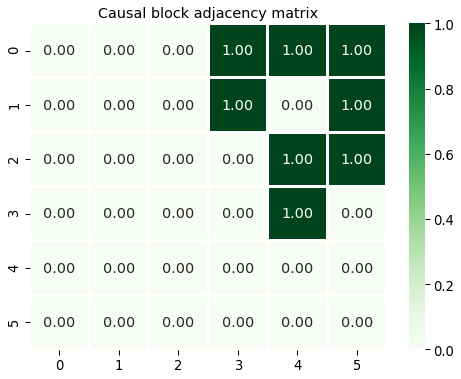

In [14]:
handler.visualiser = ModelVisualiser(handler.model, handler.dataloader.test, **handler.config["vis_params"])
figure_params = {"figsize":(8,6), "nrows":3, "N":100, "markersize":10, "font_scale":10, "vmin":0.0, "vmax":1.0}

tau = temperature_exponential_annealing(100000)

A = get_causal_block_graph(handler.model, handler.model_name, handler.device, tau=tau)
fig = handler.visualiser.plot_heatmap(A.detach().cpu(),title="Causal block adjacency matrix",
                                      threshold=0.0, **figure_params)

In [ ]:

tau = temperature_exponential_annealing(100000)

A = get_causal_block_graph(handler.model, handler.model_name, handler.device, tau=tau)
fig = handler.visualiser.plot_heatmap(A.detach().cpu(),title="Causal block adjacency matrix",
                                      threshold=0.0, **figure_params)

# Traversal Responses

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"xunit_dim4E",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

In [ ]:
figure_params = {"figsize":(25,15), "nrows":2, "population":False, 
                 "normalise":True, "markersize":10, "font_scale":11, "ylim":3}
other_args = {"num_samples":50, "steps":20, "prior_mode":"hybrid", "relative":False}

res = handler.plot_model(do_originals=False, do_reconstructions=True,
                         do_random_samples=False, do_traversals=False, 
                         do_loss2distortion=False, do_marginal=False, 
                         do_loss2marginal=False, do_traversal_responses=True, 
                         **figure_params, **other_args)

In [ ]:
fig = res['trvs_responses']
fname = fig_path / ("trvs_responses"+params["model_name"]+".png")
if os.path.isfile(fname):
    os.remove(fname)
fig.savefig(fname)

## Response field

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')

In [ ]:
i = 2; j = 5;
figure_params = {"figsize":(9,7), "title":"Latent Response Mean Field", "i":i, "j":j, 
                 "type":"contour", "contour_n":20, "surface":True}
other_args = {"num_samples":10, "grid_size":10, "prior_mode":"hybrid"}

res = handler.plot_model(do_reconstructions=True, 
                         do_marginal=False,  
                         do_latent_response_field=True,
                         **figure_params, **other_args)

## X joint marginals

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
#handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(9,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

In [ ]:

for i in range(6):
    for j in range(i):
        other_args = {"i":i, "j":j, "num_samples":20, "marginal_samples":100, 
                      "prior_mode":"uniform", "with_line":True}
        res = handler.plot_model(do_reconstructions=False, 
                                 do_marginal=False, 
                                 do_jointXmarginals=True,
                                 **figure_params, **other_args)

## Hybrids on X

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(9,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

In [ ]:
from visualisations import vis_latents, vis_xnets

In [ ]:
# plotting from the same samples for comparison 

print(f"Plotting hybridisation on the noise variables")
other_args = {"prior_mode":"posterior", "single_sample":True}
hybrids, base , other  = vis_latents.hybridiseN(handler.model, handler.device, **other_args)
figN = handler.visualiser.plot_grid(hybrids, nrow=3, **figure_params)
            
print(f"Plotting hybridisation on the causal variables")
hybrids, base , other = vis_xnets.hybridiseX(handler.model, handler.device, base=base, other=other, **other_args)
figX = handler.visualiser.plot_grid(hybrids, nrow=3, **figure_params)

In [ ]:
hybrids, base

## Double hybridisation on N and X

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"xunit_dim7",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(9,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

In [ ]:
# plotting from the same samples for comparison 

other_args = {"prior_mode":"posterior", "single_sample":True}
res = handler.plot_model(do_reconstructions=False,   
                         do_double_hybridsXN=True,
                         **figure_params, **other_args)
            

## Multidim unit marginals 

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"xunit_dim4",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(9,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

In [ ]:
for u in range(6): 
    figure_params = {"figsize":(9,7), "title":f"2D plot of unit {u}","with_points":True}
    other_args = {"num_samples":1000, "prior_mode":"posterior", "unit":u}

    res = handler.plot_model(do_reconstructions=False,   
                         do_unitMarginal=True,
                         **figure_params, **other_args)

## Marginal X 

(only for univariate models)

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(14,14), "pair":True, "bins":200}
other_args = {"num_batches":10, "prior_mode":"posterior"}

res = handler.plot_model(do_reconstructions=False, do_marginalX=True, **figure_params, **other_args)

## X response field

(only for univariate models)

In [ ]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

In [ ]:
i = 2; j = 5;
figure_params = {"figsize":(9,7), "title":"X Response Mean Field", "i":i, "j":j, 
                 "type":"contour", "contour_n":20, "surface":True, "range_limit":10}
other_args = {"num_samples":30, "grid_size":10, "prior_mode":"hybrid"}

res = handler.plot_model(do_reconstructions=False, do_latent_response_fieldX=True, **figure_params, **other_args)

## N-X relation

In [26]:
params = {"model_name":"XCAE",
          "model_version":"standardS",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint('final')
handler.reset_tau(100000)

configs/models/XCAE/standardS.yaml
128
Initialising schedulers Manager...
Causal mode ON
Explicit mode ON
XCAE model hanlder loaded.
Tau set to 1.0
Loading selected checkpoint at logs\XCAE\standardS_MNIST\checkpoints/final.ckpt
128
MODEL SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
              Mish-3           [-1, 32, 14, 14]               0
       BatchNorm2d-4           [-1, 32, 14, 14]              64
         ConvBlock-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 32, 14, 14]           9,248
              Mish-7           [-1, 32, 14, 14]               0
       BatchNorm2d-8           [-1, 32, 14, 14]              64
         ConvBlock-9           [-1, 32, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]  

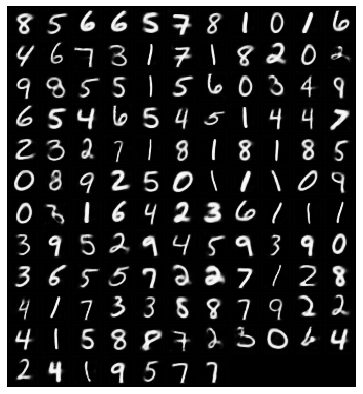

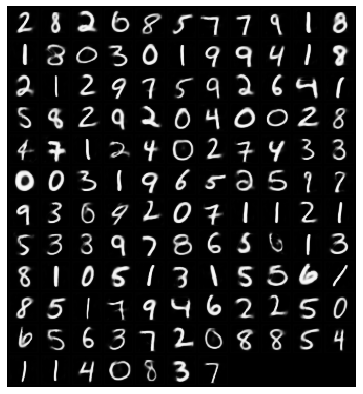

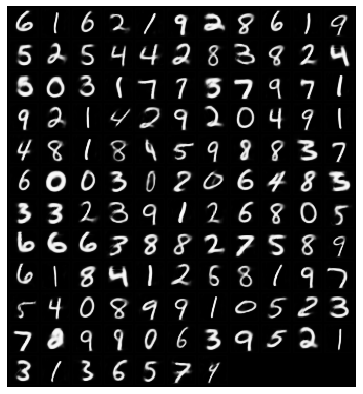

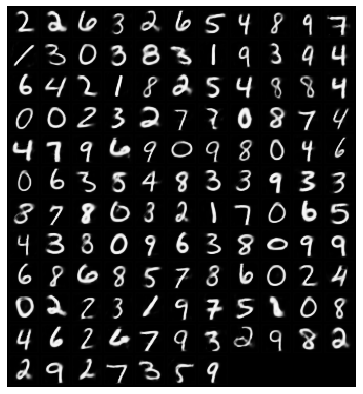

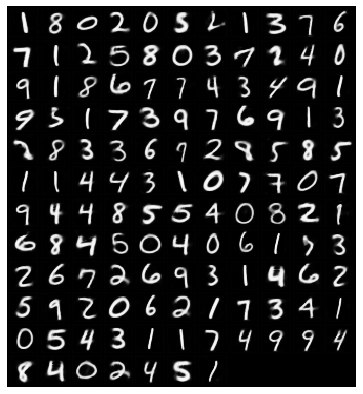

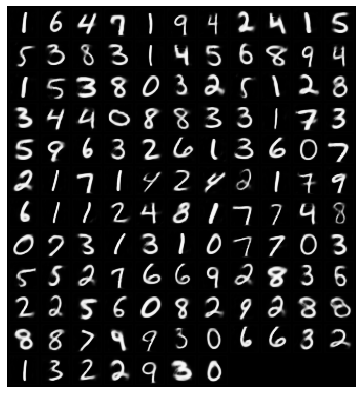

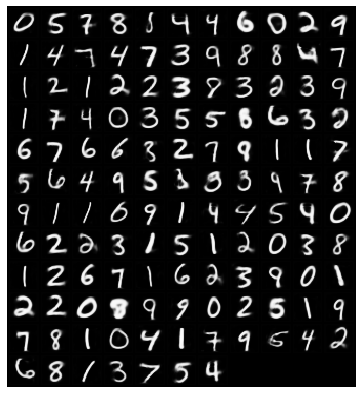

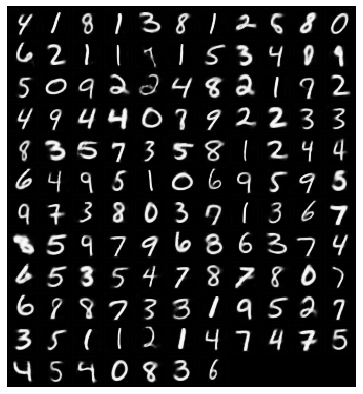

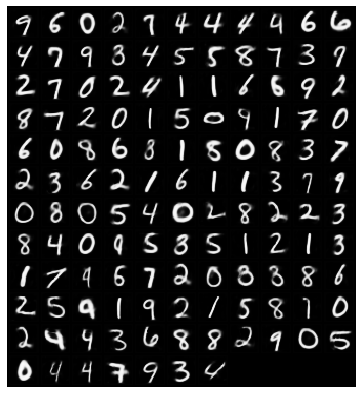

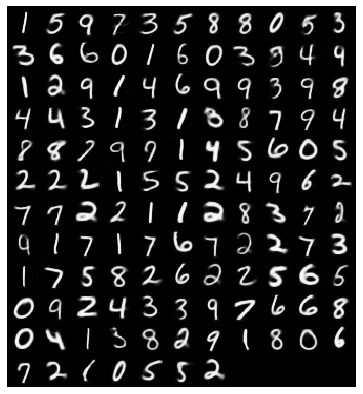

In [27]:
figure_params = {"figsize":(9,7), "new_batch":True}
# warming up the prior 
for w in range(10): res = handler.plot_model(do_reconstructions=True, **figure_params)

Plotting N3-X3 joint marginal
Computing joint between N3 and X3


c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\giulia\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


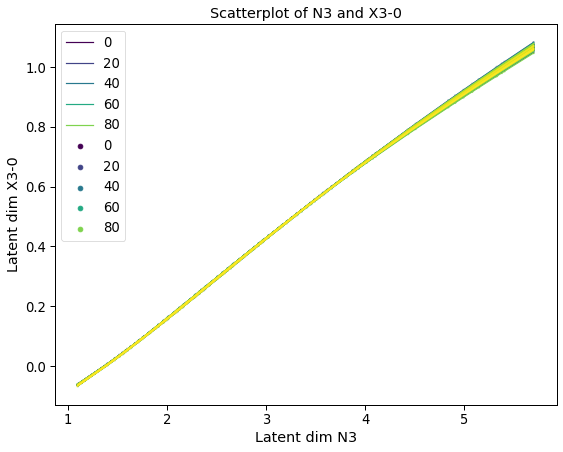

In [28]:
figure_params = {"figsize":(9,7), "new_batch":True}
i = 3; j=3;
other_args = {"dimN":i, "dimX":j, "num_samples":100, "marginal_samples":100, 
              "prior_mode":"posterior", "with_line":True}
res = handler.plot_model(do_reconstructions=False, do_N2X=True,
                         **figure_params, **other_args)

In [ ]:

for i in range(6):
    other_args = {"dim":i, "num_samples":100, "marginal_samples":100, 
                  "prior_mode":"uniform", "with_line":True}
    res = handler.plot_model(do_reconstructions=False, do_N2X=True,
                             **figure_params, **other_args)

## Interpolation

In [ ]:
params = {"model_name":"XCVAE",
          "model_version":"xunit_dim4",
          "data" : "MNIST"}

# load handler
handler = VisualModelHandler.from_config(**params)
handler.config["logging_params"]["save_dir"] = "./logs"
handler.load_checkpoint()
handler.reset_tau(100000)

In [ ]:
figure_params = {"figsize":(20,10)}
other_args = {"random_seed":13,"num_steps":20}
res = handler.plot_model(do_reconstructions=False, do_interpolationN=True,
                             **figure_params, **other_args)